# MFCC / speaker prediction / LSTM

In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [6]:
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
import numpy as np
import librosa


def fft_plot(data,fs):
    # fs = Sampling rate
    L = len(data) # Signal length（サンプル数）

    data_length = L /fs
    delta_freq = 1/data_length
    
    # 窓関数
    win = hamming(L)

    # フーリエ変換
    spectrum = fft(data * win) # 窓関数あり
    half_spectrum = abs(spectrum[: int(L / 2) + 1])
    
    # mfccs translation
    mfccs = mfcc(data, sr=fs, n_mfcc=20, n_fft=4096)
    
    # 図を表示
    fig = plt.figure(figsize=(18,10))

    fig.add_subplot(311)
    plt.plot(data)
    plt.xlim([0, L])
    plt.grid()
    plt.title("1. Input signal", fontsize = 15)

    fig.add_subplot(312)
    plt.plot(half_spectrum)
    plt.xticks([i for i in range(len(half_spectrum))][::100],[i*delta_freq for i in range(len(half_spectrum))][::100])
    plt.grid()
    plt.title("2. Spectrum (with window)", fontsize = 15)

    fig.add_subplot(313)
    plt.plot(mfccs[1:])
    plt.grid()
    plt.title("3. MFCC (without DC)", fontsize = 15)
    
    plt.show()

    return (np.arange(len(spectrum))*delta_freq, spectrum)

In [7]:
from librosa.core import stft, spectrum
from librosa.filters import mel, dct

def mfcc(y, sr=22050, n_mfcc=20, n_fft=2048, center=False, power=2.):

    abs_spectrum = np.abs(spectrum.stft(y, n_fft=n_fft, center=False))**power

    mel_basis = mel(sr, n_fft, n_mels=512)
    melspec = np.dot(mel_basis, abs_spectrum)

    S =spectrum.power_to_db(melspec)

    return np.dot(dct(n_mfcc, S.shape[0]), S)



In [2]:
import sqlite3


conn = sqlite3.connect("./train-clean-100.db")
cur = conn.cursor()
cur.execute('''select distinct readerID, gender from data''' )
obj = cur.fetchall()
conn.close()

In [3]:
import collections
collections.Counter([j for i,j in obj])


Counter({0: 126, 1: 125})

In [4]:
gender_dict = {k:v for k,v in obj}

In [5]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

#     print("Sampling rate :", fs)
#     print("Sample num :",len(data))
    
    return fs,data


def write_wav(file_path, fs, data):
    from scipy.io.wavfile import write
    try:
        write(file_path,fs, data)
        return 1
    except:
        return 0


In [8]:
# データのインポート

import pickle
with open("mfcc_lstm_data_4096.dump","rb") as f:
    (all_data, all_labels, all_speakers) = pickle.load(f,encoding="bytes")

In [9]:
all_data.shape

(15237, 4096)

In [10]:
def dens_threshold(data, th, win=100):
    # 閾値
    L = len(data)
    abs_sum = []
    for i in range(int(L/100)):
        d = data[i*100:(i+1)*100]
        abs_sum.append(np.sum(np.array([np.abs(x) for x in d]))//100.)

    pos = 0; neg = 0
    for i in abs_sum:
        if i >= 800.:
            pos += 1
        else:
            neg += 1
#     print("pos:",pos,"neg:",neg,"/",int(L/100))
    if pos/int(L/100) > 0.5:
        return 1
    else:
        return 0

In [11]:
%%time

all_data_label_speaker = np.array([(x,y,z) for x,y,z in zip(all_data,all_labels,all_speakers) if dens_threshold(x, 800)])

all_data = np.array([x for x,y,z in all_data_label_speaker])
all_labels = np.array([y for x,y,z in all_data_label_speaker])
all_speakers = np.array([z for x,y,z in all_data_label_speaker])

CPU times: user 1min 1s, sys: 589 ms, total: 1min 2s
Wall time: 1min 4s


In [12]:
all_data.shape

(5591, 4096)

In [13]:
# データのシャッフル

import random

indices = np.arange(len(all_data))
np.random.shuffle(indices)
all_data = all_data[indices]
all_labels = all_labels[indices]
all_speakers = all_speakers

In [14]:
# trainとtestデータのセット

x_train = all_data[:5200]
y_train = all_labels[:5200]
x_test = all_data[5200:]
y_test = all_labels[5200:]
s_train = all_speakers[:5200]
s_test = all_speakers[5200:]

In [205]:
# ためしに聞いてみたい場合

# path ="./wav_samples/103-1240-0000.flac.wav"
# fs,data = load_wav(path)
# write_wav("test.wav",fs,data[:20000])

1

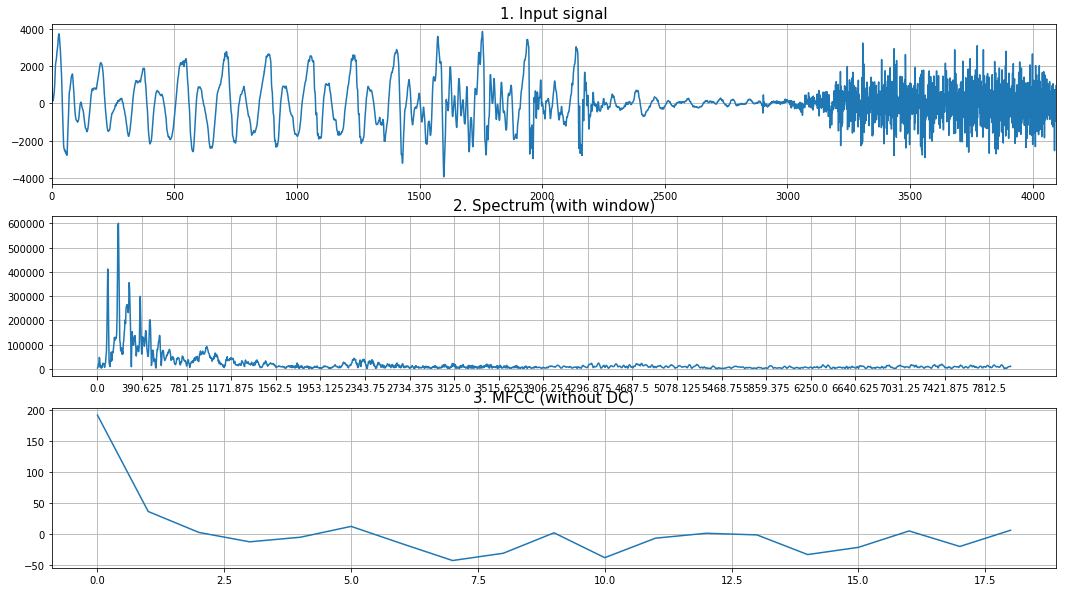

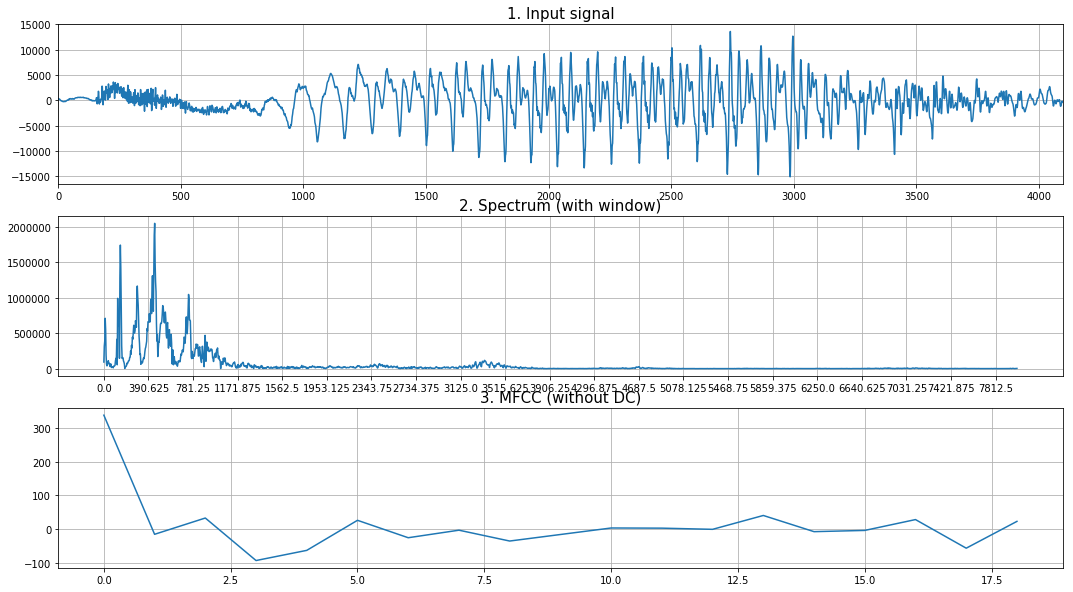

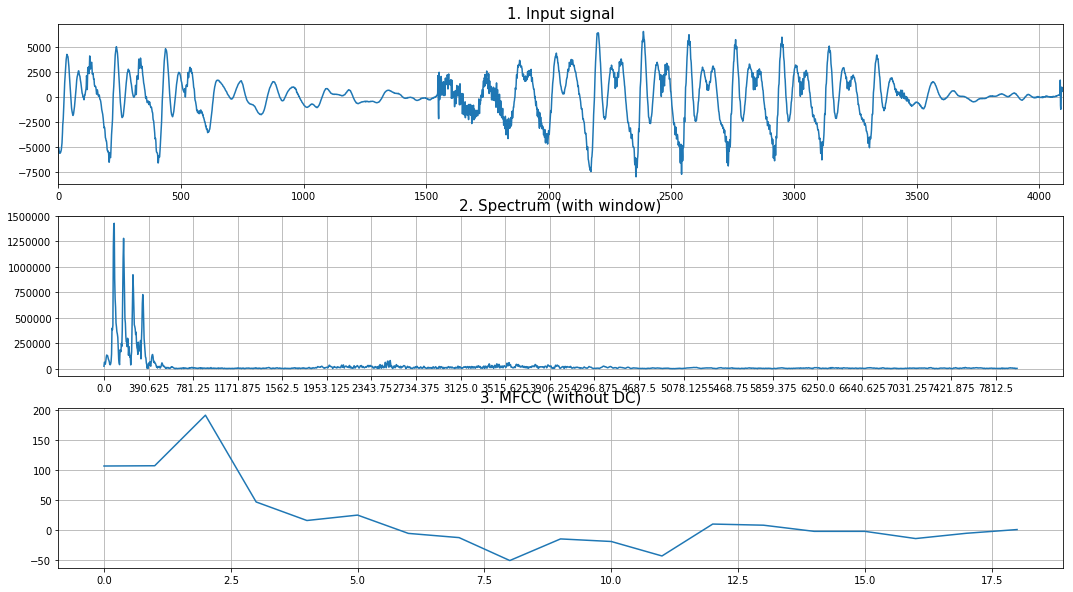

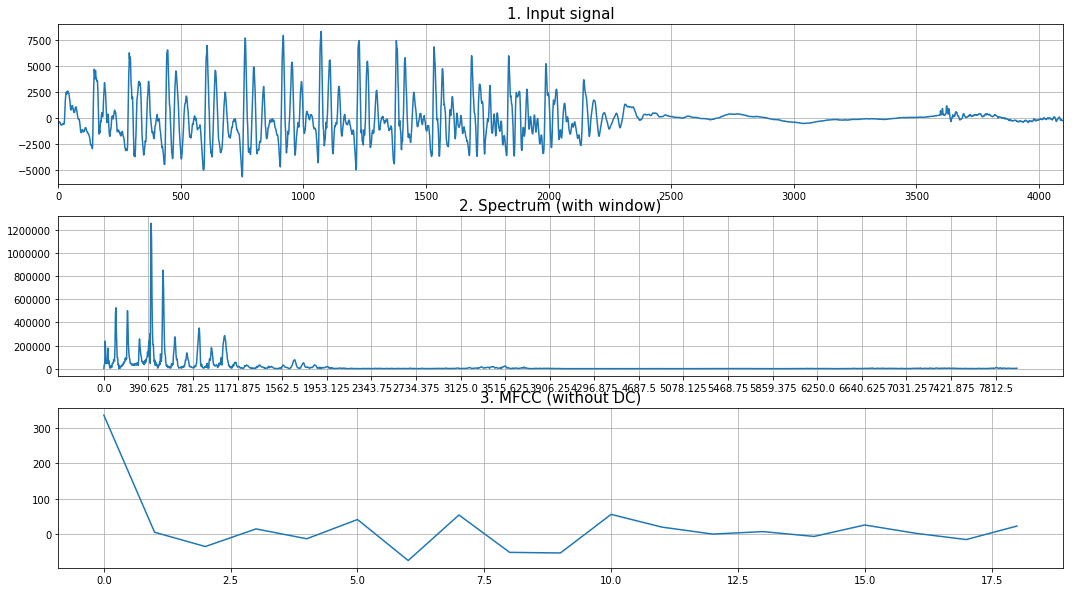

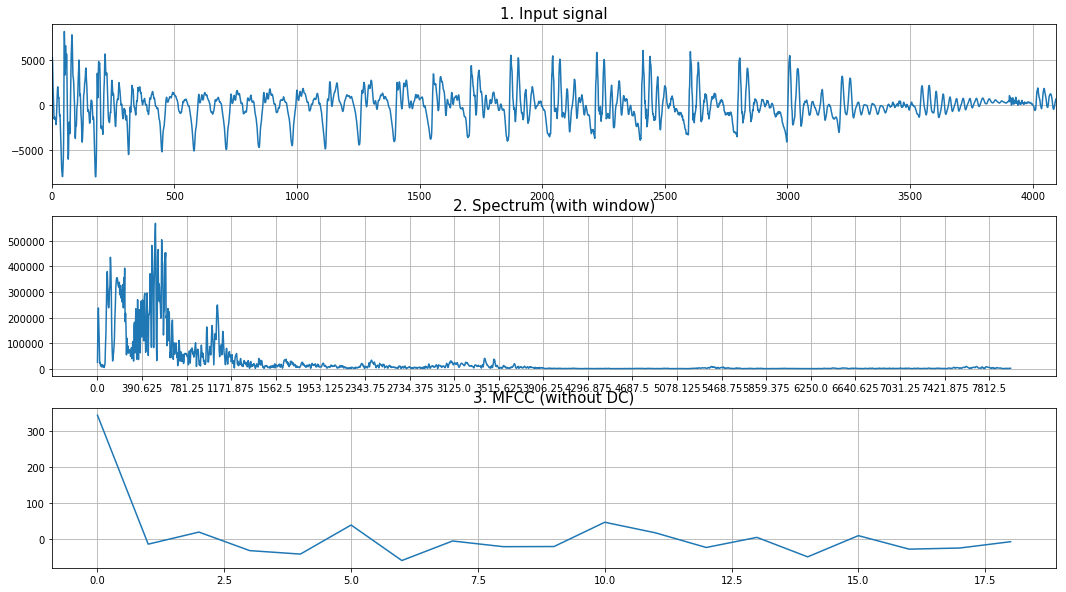

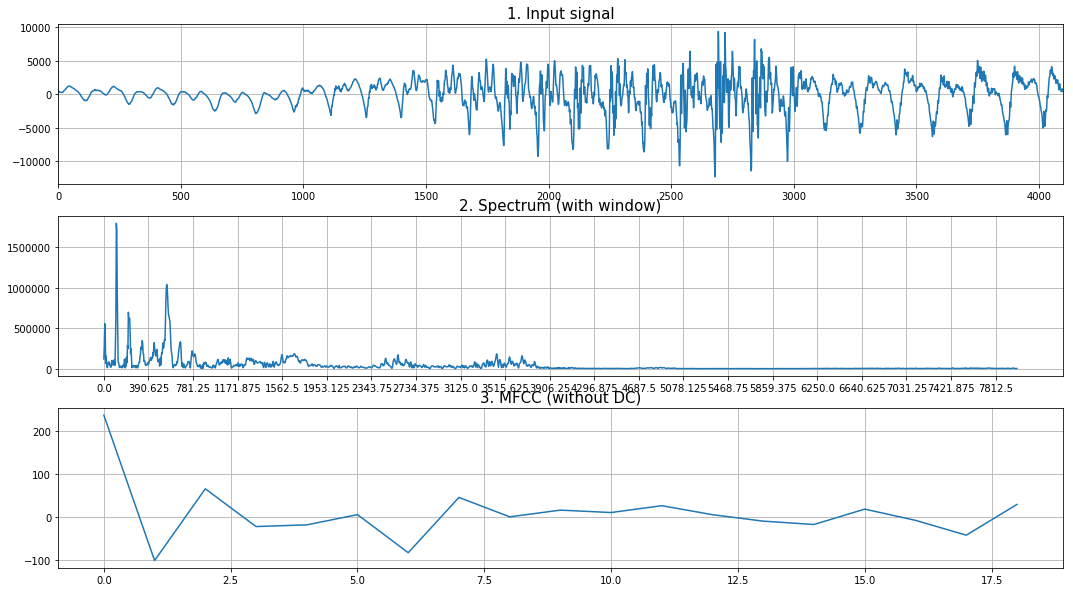

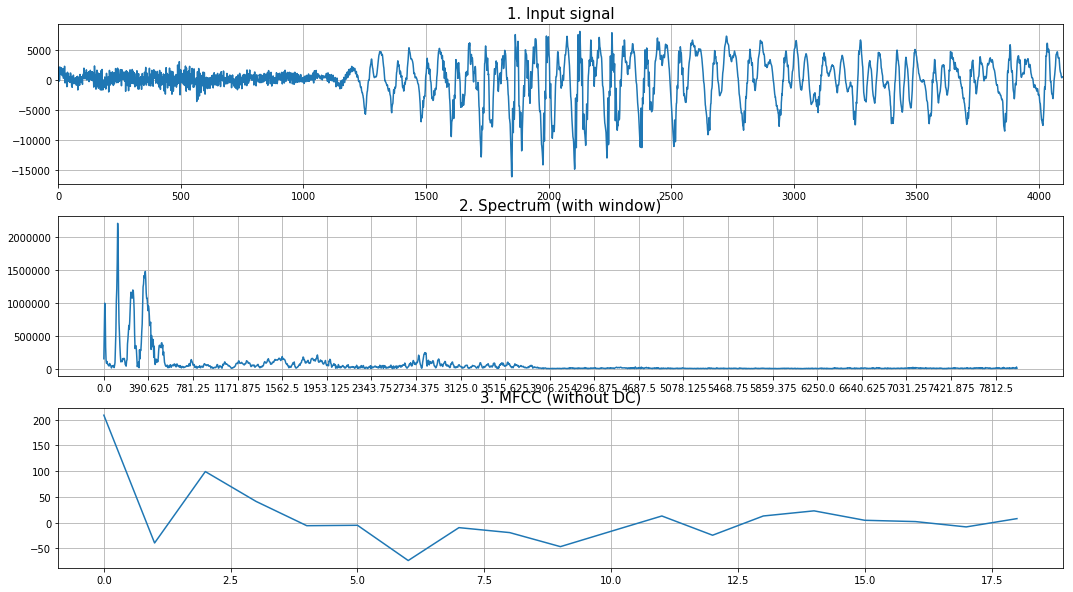

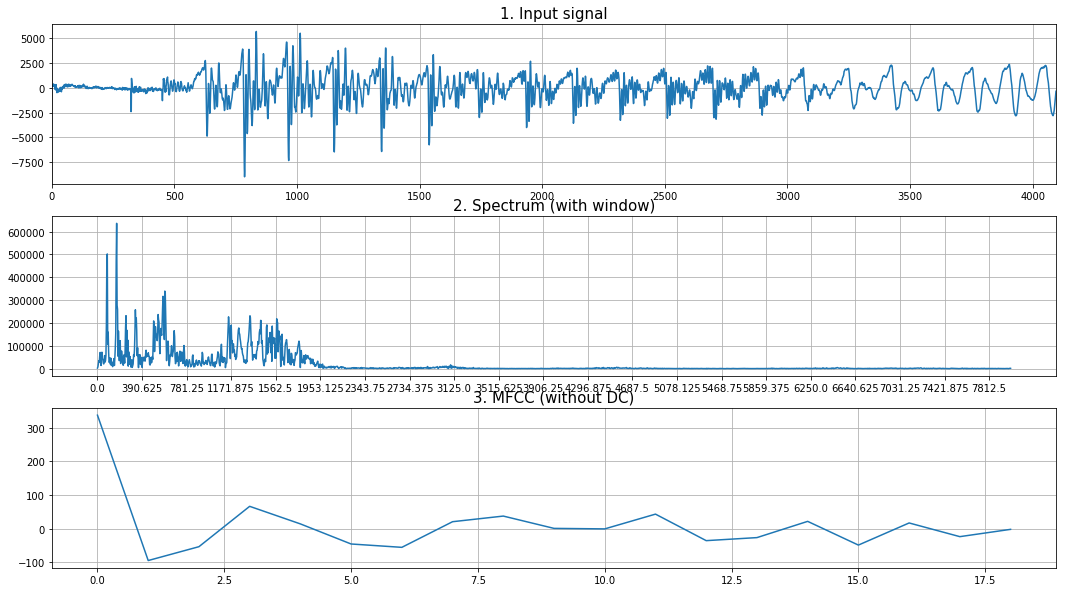

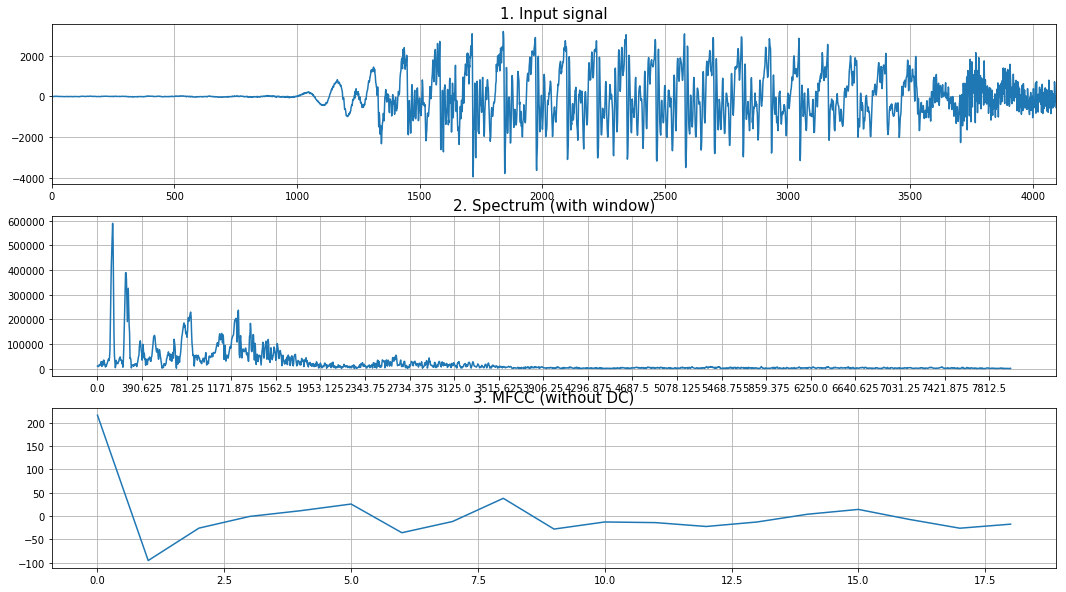

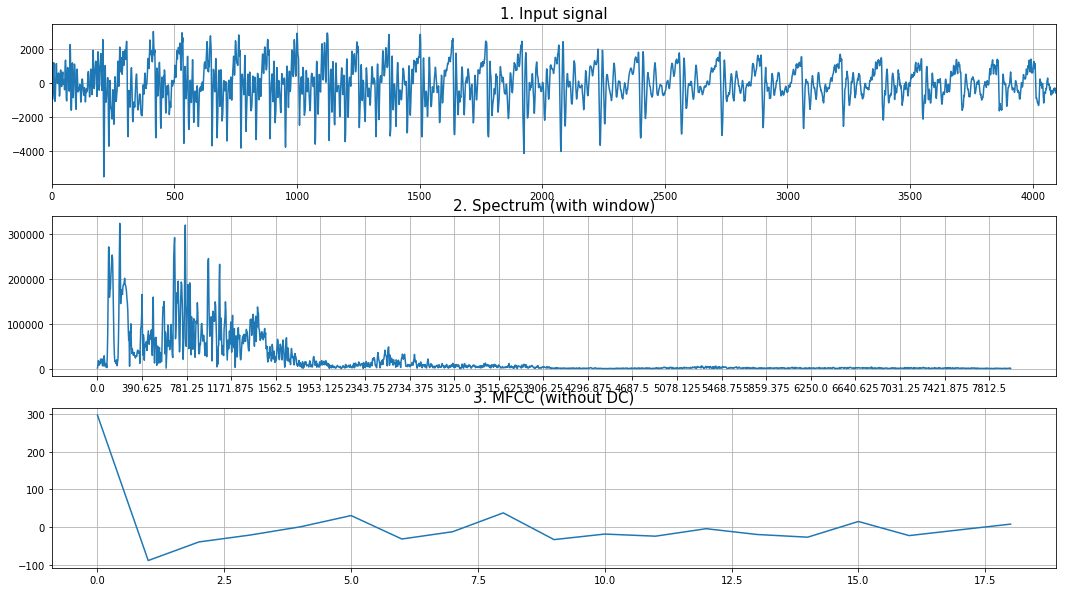

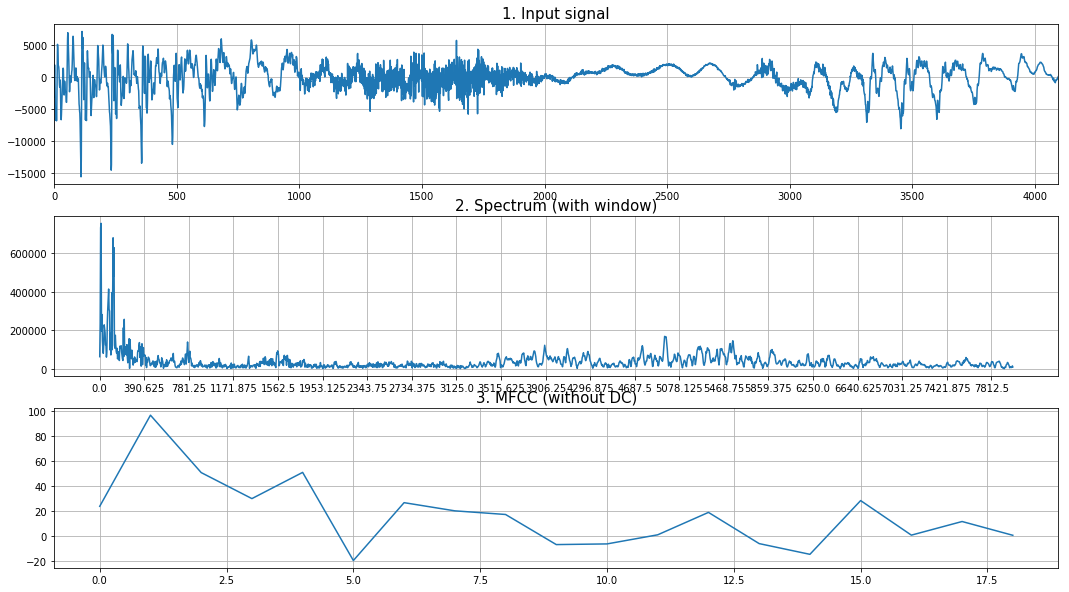

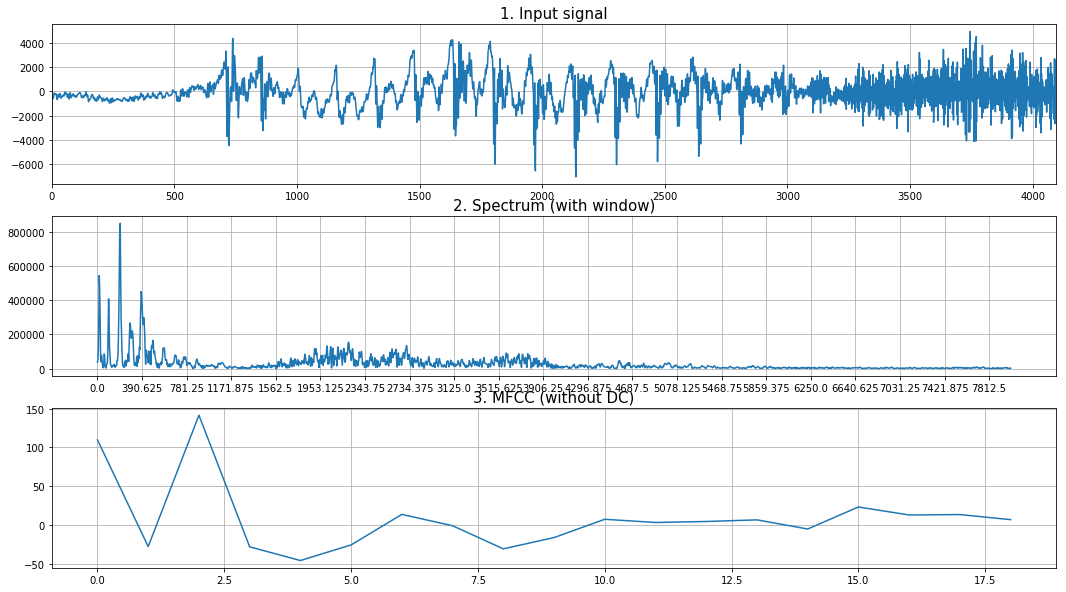

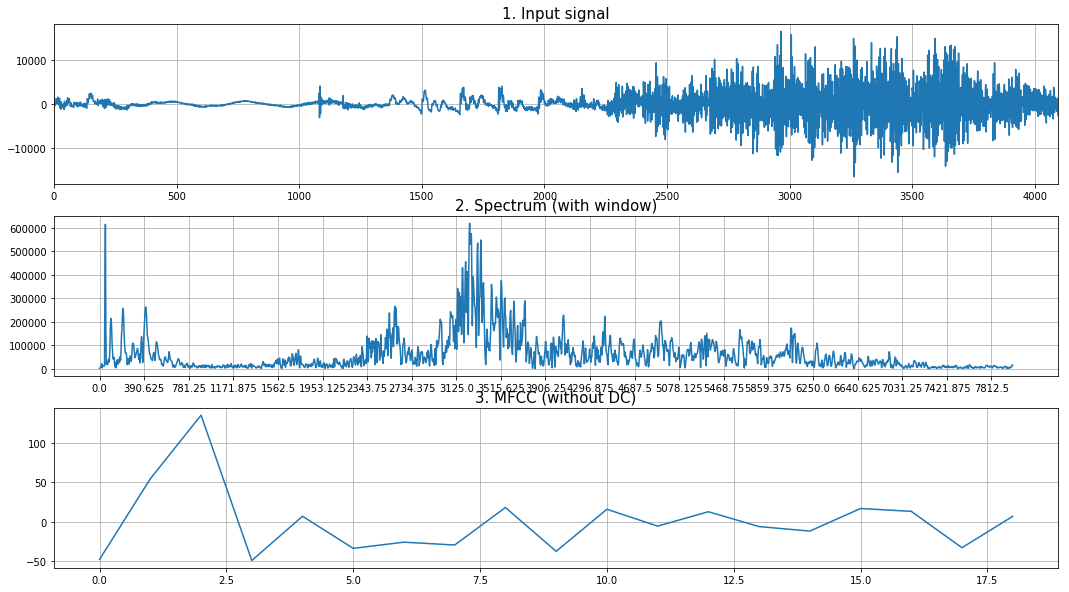

-------------------
-------------------
-------------------


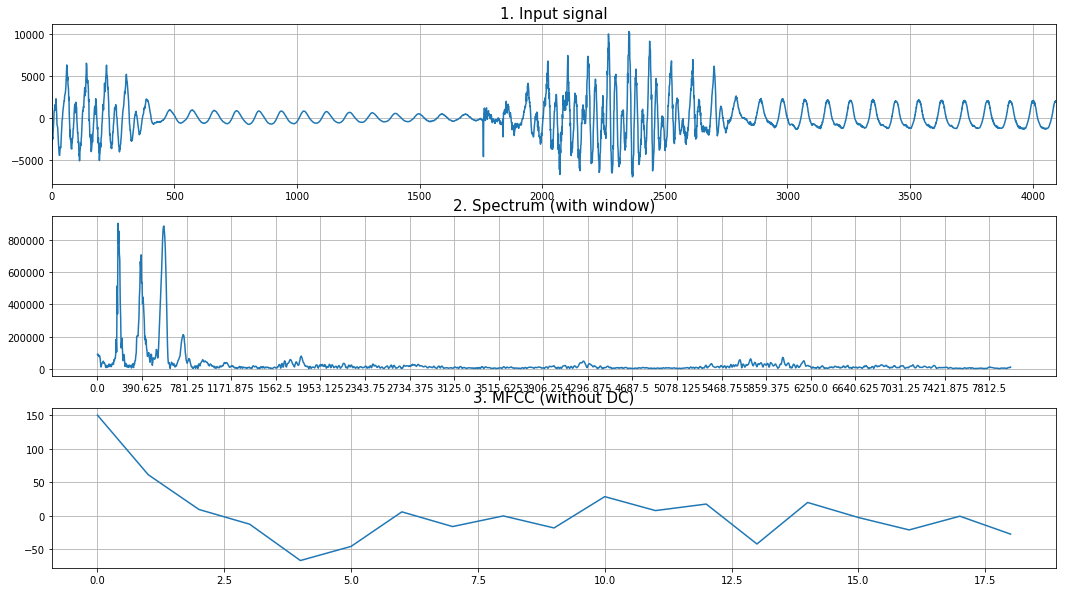

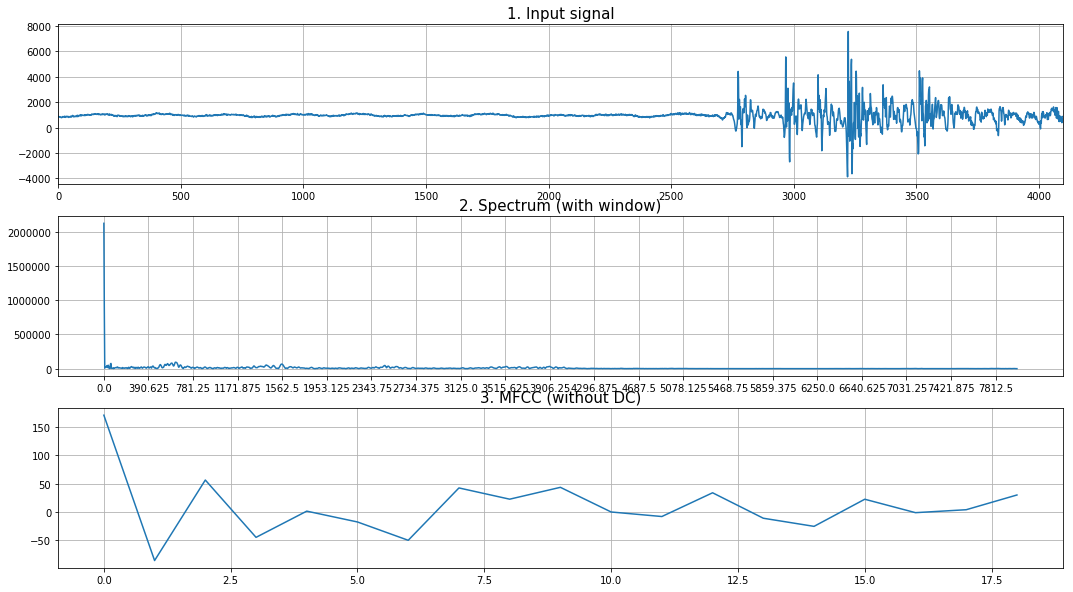

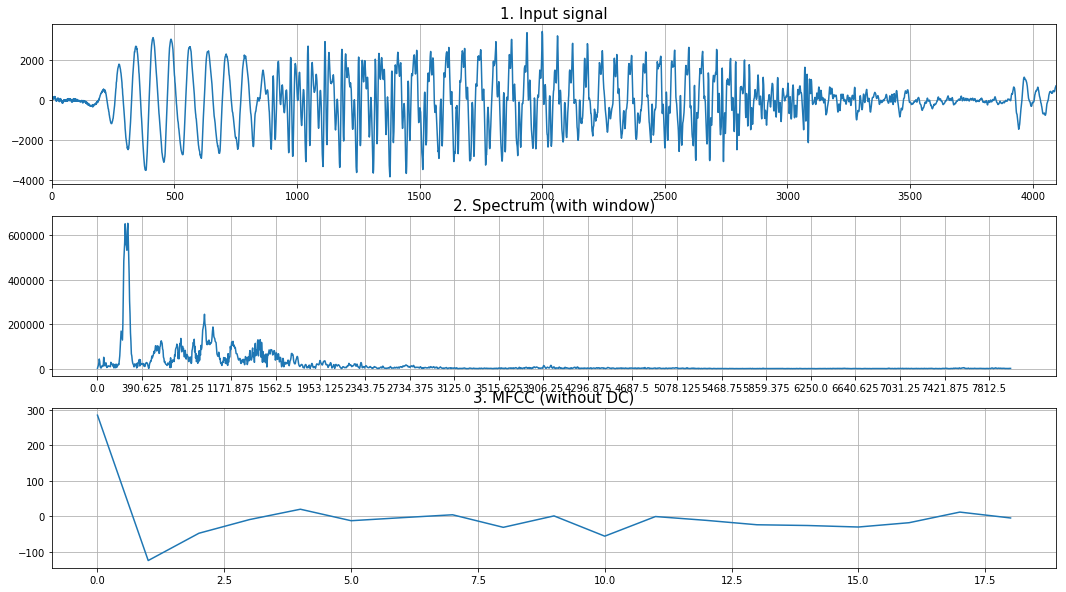

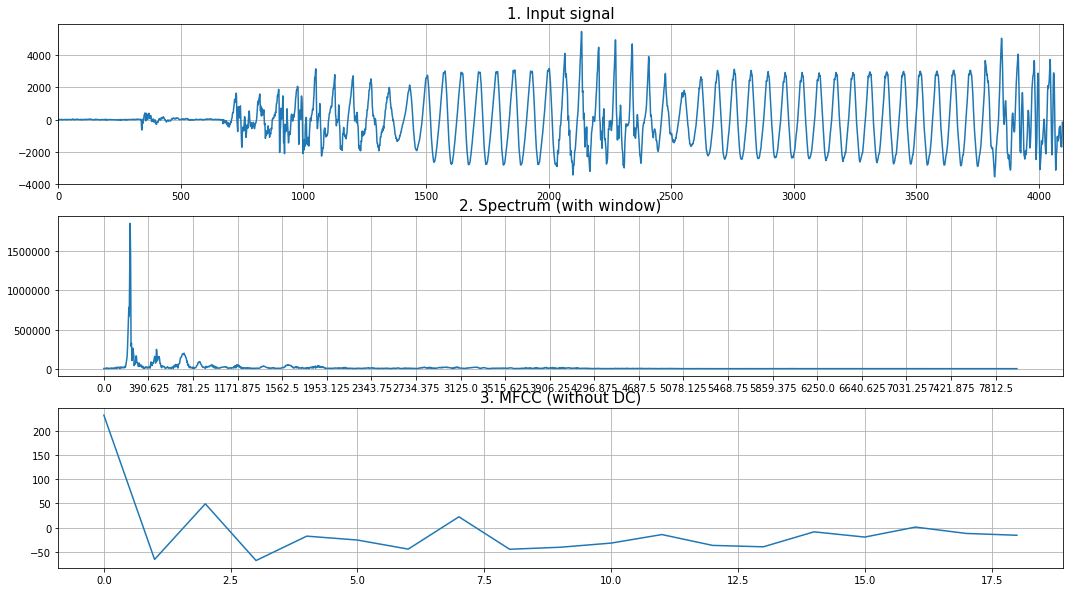

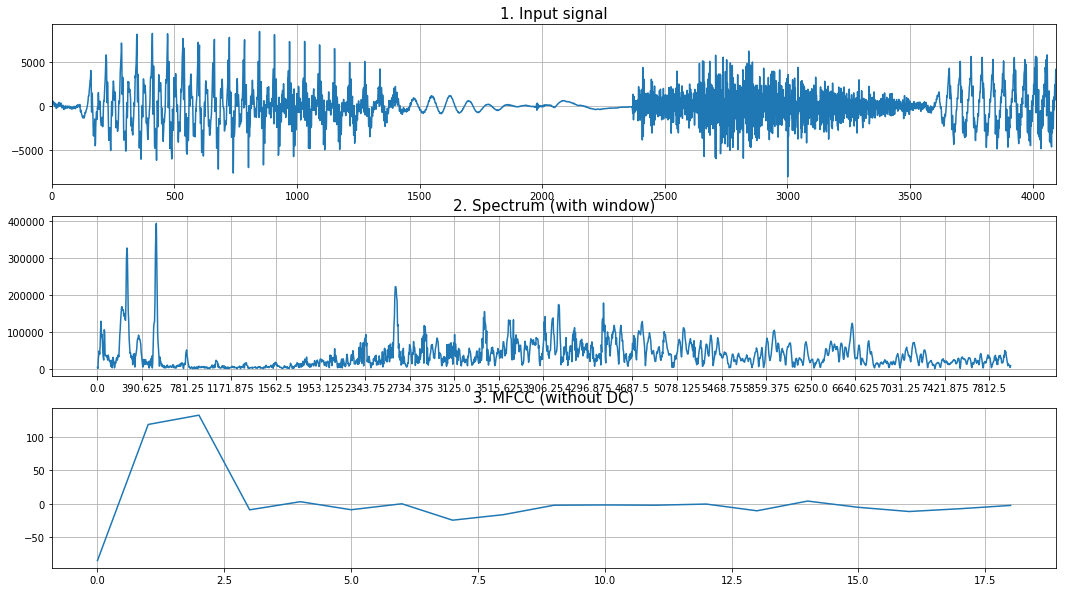

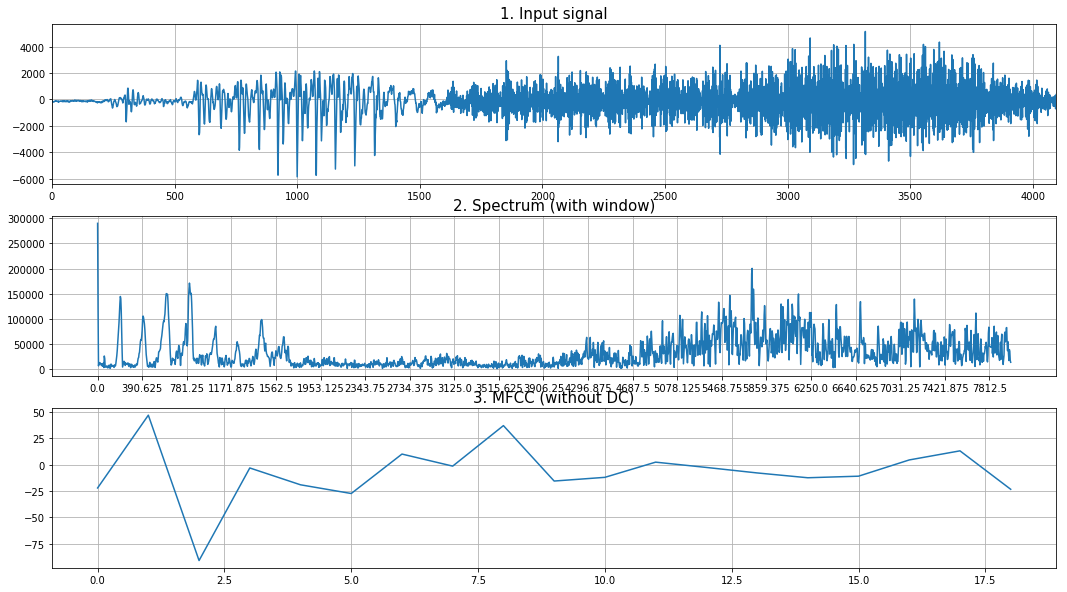

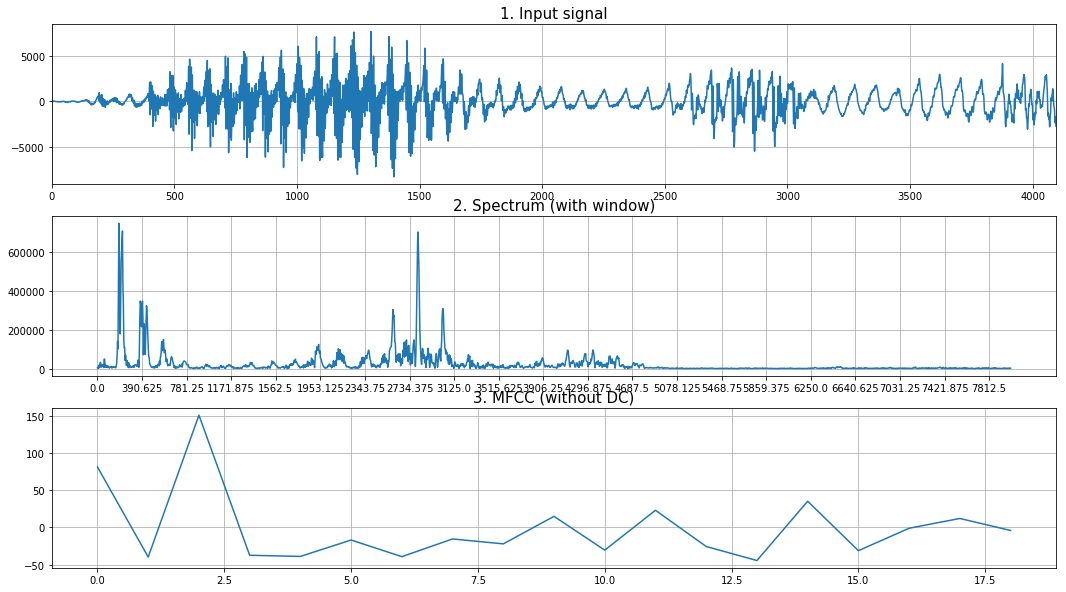

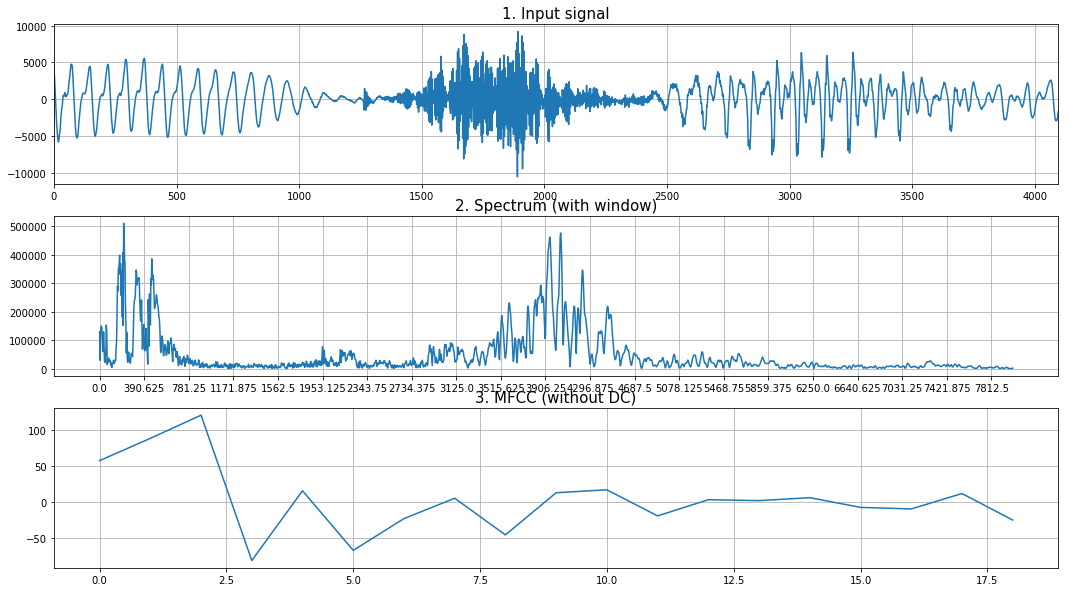

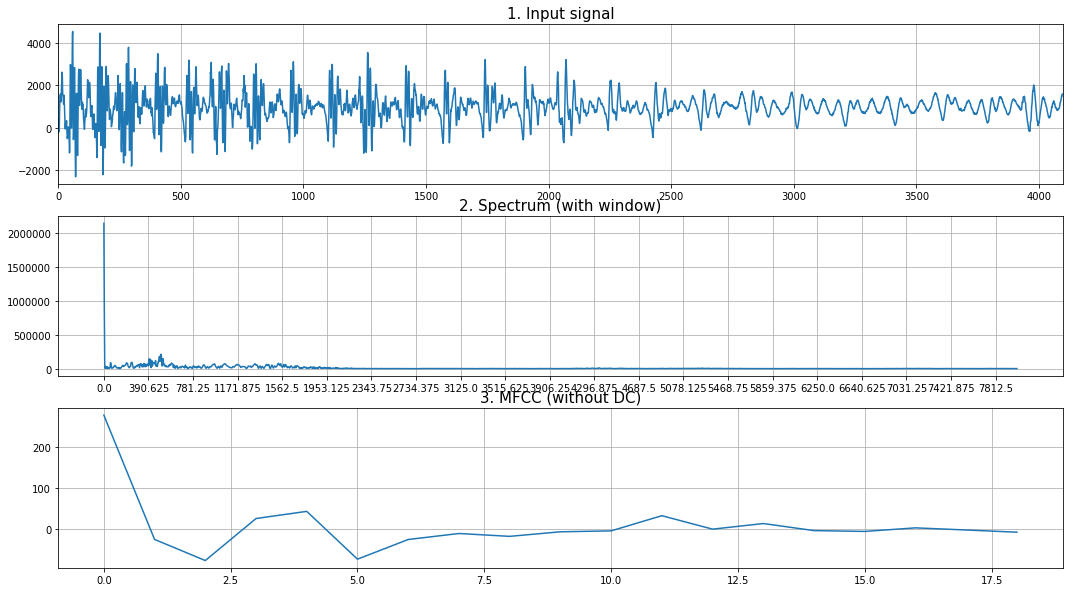

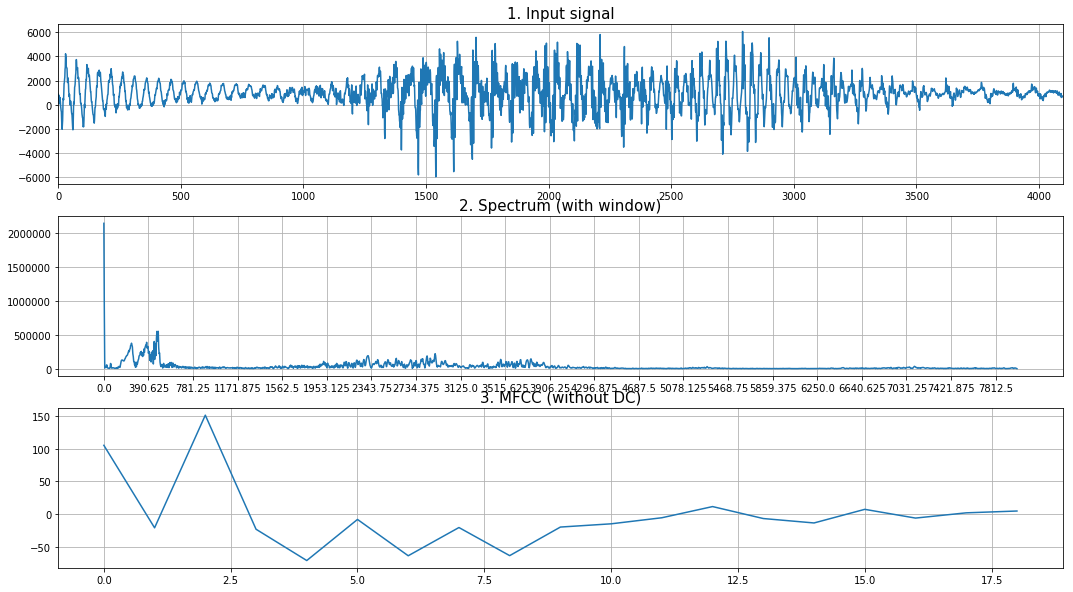

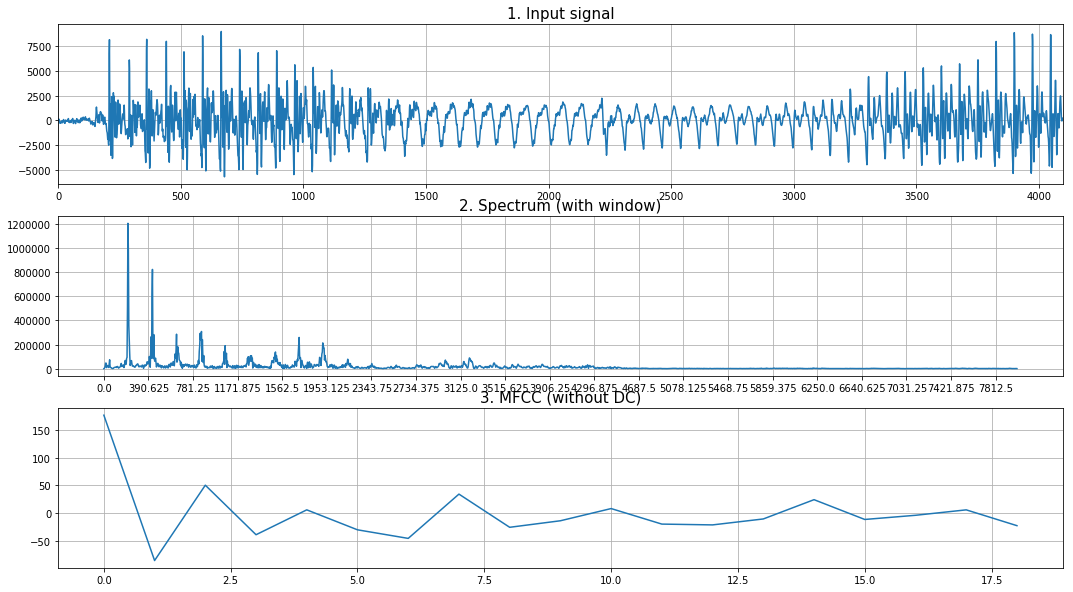

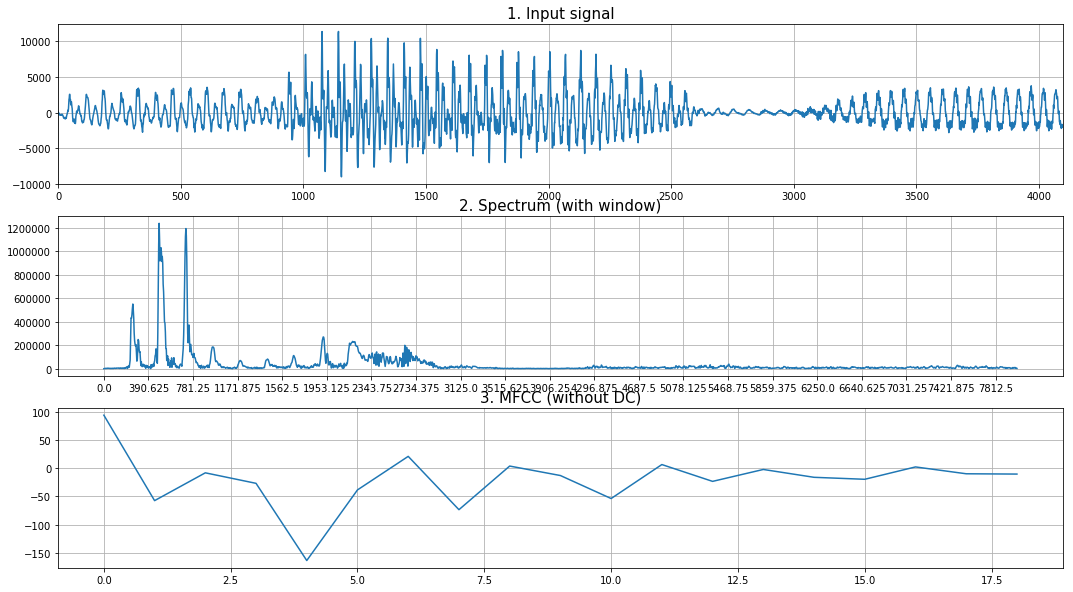

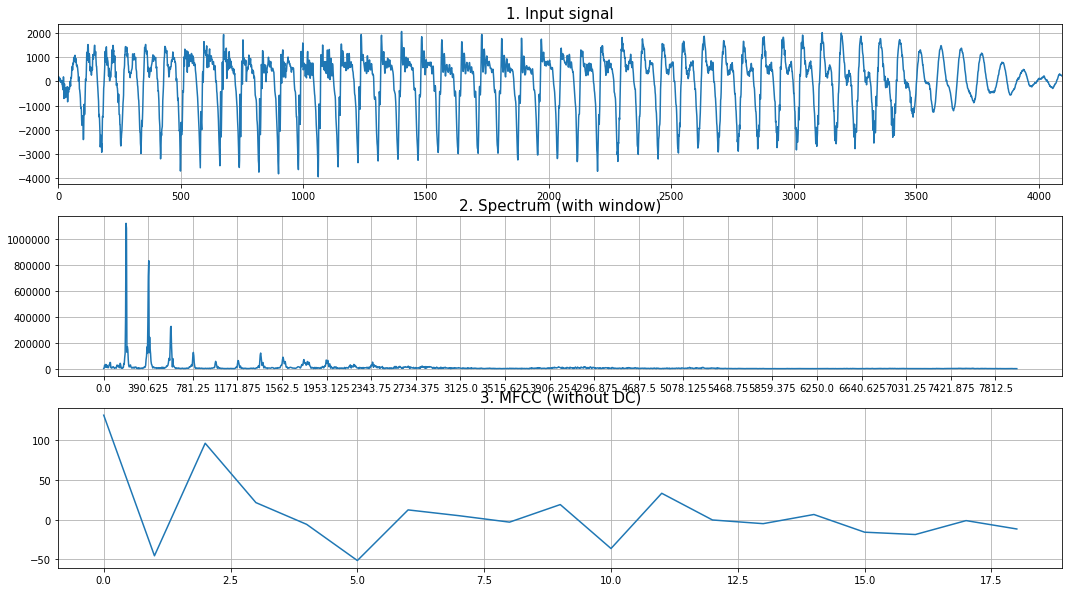

In [15]:
e = 0
for x,y in zip(x_train[500:700],y_train[500:700]):
    if y == 0:
        fft_plot(x,16000)
        e +=1
    if e>12:
        break
    
print("-------------------")
print("-------------------")
print("-------------------")
        
e = 0
for x,y in zip(x_train[:100],y_train[:100]):
    if y == 1:
        fft_plot(x,16000)
        e +=1
    if e>12:
        break
        

In [16]:
print(x_train.shape)
print(x_test.shape)

(5200, 4096)
(391, 4096)


In [17]:
%%time

X_train = np.array([mfcc(x, sr=16000, n_mfcc=13, n_fft=4096) for x in x_train])
X_test = np.array([mfcc(x, sr=16000, n_mfcc=13, n_fft=4096) for x in x_test])

CPU times: user 1min 47s, sys: 12 s, total: 1min 59s
Wall time: 2min 3s


In [121]:
# Xx_train = np.array([x.T for x in X_train]).reshape(8500*6,13)
# Xx_test = np.array([x.T for x in X_test]).reshape(-1,13)

In [149]:
# print(y_train.shape)
# Yy_train = np.array([np.zeros(6) if y == 0. else np.ones(6) for y in y_train]).flatten()
# Yy_test = np.array([np.zeros(6) if y == 0. else np.ones(6) for y in y_test]).flatten()
# print(Yy_train.shape)

(8500,)
(51000,)


In [122]:
# Xd_train = np.array([[x,librosa.feature.delta(x)] for x in Xx_train])
# Xd_test = np.array([[x,librosa.feature.delta(x)] for x in Xx_test])

In [123]:
# Xdd_train = np.array([np.r_[x,y,librosa.feature.delta(y)] for x,y in Xd_train])
# Xdd_test = np.array([np.r_[x,y,librosa.feature.delta(y)] for x,y in Xd_test])

In [127]:
# Xdd_train = Xdd_train.reshape(-1,39,1)
# Xdd_test = Xdd_test.reshape(-1,39,1)

In [168]:
X_train = X_train.reshape(-1,13,1)
X_test = X_test.reshape(-1,13,1)

In [169]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers import Activation
from keras.layers import LSTM, Dense, Embedding, Bidirectional

In [170]:
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [153]:
with open("mfcc_lstm_data_10000_train_test.dump", "wb") as f:
    pickle.dump((Xdd_train,Y_train,Xdd_test,Y_test),f)

In [173]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 50

# LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(13,1)))

model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5200, 13, 1)
(5200, 2)
(391, 13, 1)
(391, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_20 (Activation)   (None, 2)                 0         
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________
Train on 5200 samples, validate on 391 samples
Epoch 1/50
5200/5200 [==============================] - 7s - loss: 0.6570 - acc: 0.6331 - val_loss: 0.6276 - val_acc: 0.6496
Epoch 2/50
5200/5200 [==============================] - 6s - loss: 0.5856 - acc: 0.6862 - val_loss: 0.6461 - val_acc: 0.6522
Epoch 3/50
5200/5200 [==============================] - 6s 

In [174]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 50

# Deep LSTM model
model2 = Sequential()
model2.add(LSTM(64, input_shape=(13,1), return_sequences=True))
model2.add(LSTM(64))


model2.add(Dense(2))
model2.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model2.summary()

# フィッティング(学習)
history = model2.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5200, 13, 1)
(5200, 2)
(391, 13, 1)
(391, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 13, 64)            16896     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 130       
_________________________________________________________________
activation_21 (Activation)   (None, 2)                 0         
Total params: 50,050
Trainable params: 50,050
Non-trainable params: 0
_________________________________________________________________
Train on 5200 samples, validate on 391 samples
Epoch 1/50
5200/5200 [==============================] - 10s - loss: 0.6736 - acc: 0.6098 - val_loss: 0.6421 - val_acc: 0.6419
Epoch 2/50
5200/5200 [=============================

In [175]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

Xx_train = X_train.reshape(-1,13)
Xx_test = X_test.reshape(-1,13)

num_classes = 2
batch_size = 50
epochs = 50

# DNN model
model3 = Sequential()
model3.add(Dense(64, input_shape=(13,)))
model3.add(Dense(64))


model3.add(Dense(2))
model3.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model3.summary()

# フィッティング(学習)
history = model3.fit(Xx_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(Xx_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5200, 13, 1)
(5200, 2)
(391, 13, 1)
(391, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 130       
_________________________________________________________________
activation_22 (Activation)   (None, 2)                 0         
Total params: 5,186
Trainable params: 5,186
Non-trainable params: 0
_________________________________________________________________
Train on 5200 samples, validate on 391 samples
Epoch 1/50
5200/5200 [==============================] - 1s - loss: 7.6282 - acc: 0.5267 - val_loss: 7.4613 - val_acc: 0.5371
Epoch 2/50
5200/5200 [==============================] 

In [177]:
## Bidirectional version

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 50

# BiLSTM model
model4 = Sequential()
model4.add(Bidirectional(LSTM(64), input_shape=(13,1)))
model4.add(Dense(2))
model4.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model4.summary()

# フィッティング(学習)
history = model4.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(5200, 13, 1)
(5200, 2)
(391, 13, 1)
(391, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               33792     
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_23 (Activation)   (None, 2)                 0         
Total params: 34,050
Trainable params: 34,050
Non-trainable params: 0
_________________________________________________________________
Train on 5200 samples, validate on 391 samples
Epoch 1/50
5200/5200 [==============================] - 9s - loss: 0.6849 - acc: 0.6071 - val_loss: 0.7393 - val_acc: 0.5831
Epoch 2/50
5200/5200 [==============================] - 6s - loss: 0.6216 - acc: 0.6606 - val_loss: 0.6553 - val_acc: 0.6394
Epoch 3/50
5200/5200 [==============================] - 5s 

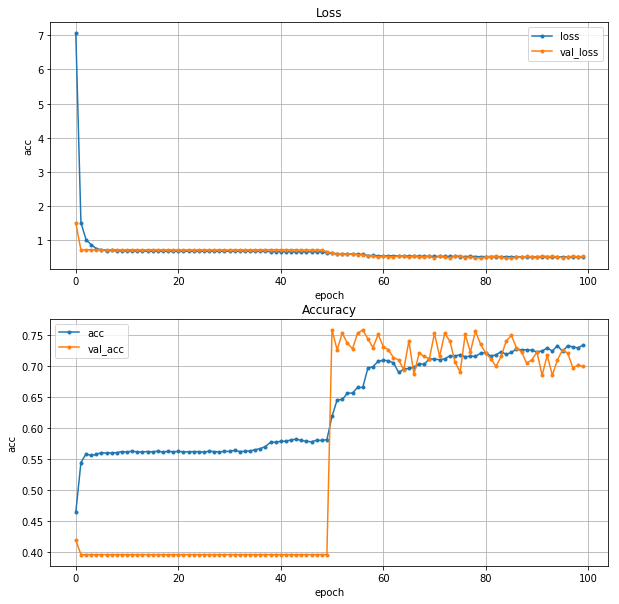

In [94]:
import matplotlib.pyplot as plt
# plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

# plt.savefig('rms_cifar3_50epochs.png')